<a href="https://colab.research.google.com/github/Zhiyuan-03/AI_in_Transportation_Exercise/blob/main/LS_IDM_proj2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Course AH2174/FAH3002 - Model calibration using trajectory data    
Lab 3- Mini Project on Car-following Model    
Date: 11.27.2025

## Objective
Calibrating and validating IDM model by using real-world vehicle trajectory data.  

## Problem description
A general formulation of the CF model calibration problem is as follows:
![image.png](attachment:image.png)
*$β$* is a vector of car-following model parameters to be calibrated  
*$F(⋅)$* is a car-following model  
*$LB_β$* and *$UB_β$* represent the lower and the upper bound for the parameters in β, respectively  
*$G(⋅)$* is a vector of constraint functions
*$MoP^{obs}$* and *$MoP^{sim}$* represent observed and simulated measure of performance (MoP), respectively  
*$f(⋅)$* is a goodness-of-fit (GoF) function  
*$f(MoP^{obs}, MoP^{sim})$* is the optimization objective function

## IDM calibration
IDM model:
![image.png](attachment:image.png)
where *$a$* is maximum acceleration  
*$b$* is desired deceleration  
*$v_0$* is desired velocity  
*$S(t)$* is spacing  
*$v_n(t)$* is following vehicle velocity  
*$v_{n-1}(t)$* is preceding vehicle velocity  
*$T$* is the lower bound of the desired time gap  
*$s_0$* is jam distance  
*$δ$* is acceleration exponent, and typical value is 4  
*$S^*$* is desired spacing  

## Data description
The data file has the trajectory data of 25 car-following pairs. The frame rate is 10fps. Each vehicle has its unique vehicle id, and each row represents the data of the follower and the leader in a frame. The definitions of given fields are listed as follows:  
Frame_ID_f: The the sequential number of each frame  
Vehicle_ID_f: The vehicle id of the follower  
x_f (m): The position the follower center point  
v_f (m/s): The velocity of the follower  
a_f ($m/s^2$): The acceleration of the follower  
length_f (m): The length of the follower  
width_f (m): The width of the follwer  
Frame_ID_l: The the sequential number of each frame  
Vehicle_ID_l: The vehicle id of the leader car  
x_l (m): The position the leader center point  
v_l (m/s): The velocity of the leader  
a_l ($m/s^2$): The acceleration of the leader  
length_l (m): The length of the leader  
width_l (m): The width of the leader  
spacing (m): The distance between the front of the following vehicle and the rear of the leading vehicle

## Calibration
GoF: RMSE, NRMSE, MAE...  
MoP: spacing, position, speed...  
Optimization algorithm: Global least square (from scipy.optimize import least_squares), genetic algorithm (GA) (import pygad), Interior Point (IP)...  
Reference: Punzo, Vincenzo, Zuduo Zheng, and Marcello Montanino. "About calibration of car-following dynamics of automated and human-driven vehicles: Methodology, guidelines and codes." Transportation Research Part C: Emerging Technologies 128 (2021): 103165.

# Code
Complete the following parts by filling the code under "`YOU CODE HERE`". You can also change the rest of the code skeleton according to your need!

In [1]:
import numpy as np
import pandas as pd

In [2]:
# 1. Load data
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
# Step 1: Upload the file (you already did this once, but keep for completeness)
uploaded = files.upload()

# Step 2: Load the uploaded CSV file
# Replace 'cf_pair25_v1.csv' with the exact filename you uploaded
data = pd.read_csv('cf_pair25_v1.csv')

# Split the data into a training set and a testing set in an 8:2 ratio.
# eg.20 car-following pairs for training, and 5 car-following pairs for testing
# YOU CODE HERE
####################################################################
# Step 3: Split the data into a training set and a testing set in an 8:2 ratio
unique_pairs = data['Vehicle_ID_f'].unique()

train_ids, test_ids = train_test_split(unique_pairs, test_size=0.2, random_state=42)

train_data = data[data['Vehicle_ID_f'].isin(train_ids)]
test_data = data[data['Vehicle_ID_f'].isin(test_ids)]

# Quick check
print("Training pairs:", len(train_ids))
print("Testing pairs:", len(test_ids))

Saving cf_pair25_v1.csv to cf_pair25_v1.csv
Training pairs: 20
Testing pairs: 5


In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load data
df = pd.read_csv('cf_pair25_v1.csv')

# IDM model
def idm_model(s, v, delta_v, params, T=1.5, v0=30, s0=1):
    a, b = params
    delta = 4
    s_star = s0 + v * T + (v * delta_v) / (2 * np.sqrt(a * b))
    acceleration = a * (1 - (v / v0) ** delta - (s_star / s) ** 2)
    return acceleration

# Calibration using Least Squares
def calibration(params, df, time_step=0.1):
    total_error = 0
    vehicle_count = 0

    grouped = df.groupby('Vehicle_ID_f')

    for vehicle_id, data in grouped:
        v_f = data['v_f'].iloc[0]
        x_f = data['x_f'].iloc[0]

        v_l = data['v_l'].values
        x_l = data['x_l'].values

        v_obs = data['v_f'].values

        v_sim = [v_f]
        x_sim = [x_f]

        for i in range(1, len(data)):
            s = x_l[i] - x_sim[-1] - data['length_l'].iloc[i]
            delta_v = v_sim[-1] - v_l[i]
            acc = idm_model(s, v_sim[-1], delta_v, params)
            new_v = v_sim[-1] + acc * time_step
            new_x = x_sim[-1] + new_v * time_step

            v_sim.append(new_v)
            x_sim.append(new_x)

        # Least Squares error (sum of squared differences)
        error = np.sum((v_obs - np.array(v_sim)) ** 2)
        total_error += error
        vehicle_count += 1

    return total_error / vehicle_count

# Objective wrapper
def objective(params, df):
    return calibration(params, df)

# Initial guess and bounds
initial_guess = [1.0, 2.0]
bounds = [(0.1, 5.0), (0.1, 5.0)]

# Run optimization
result = minimize(objective, initial_guess, args=(df,), bounds=bounds, method='L-BFGS-B')
calibrated_params = result.x

print("Calibrated Parameters:", calibrated_params)


Calibrated Parameters: [0.6802075  1.67832131]


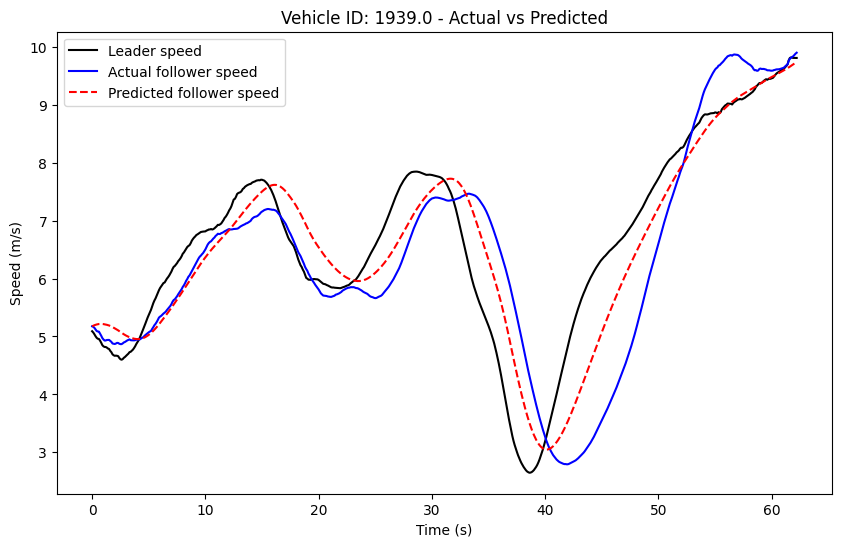

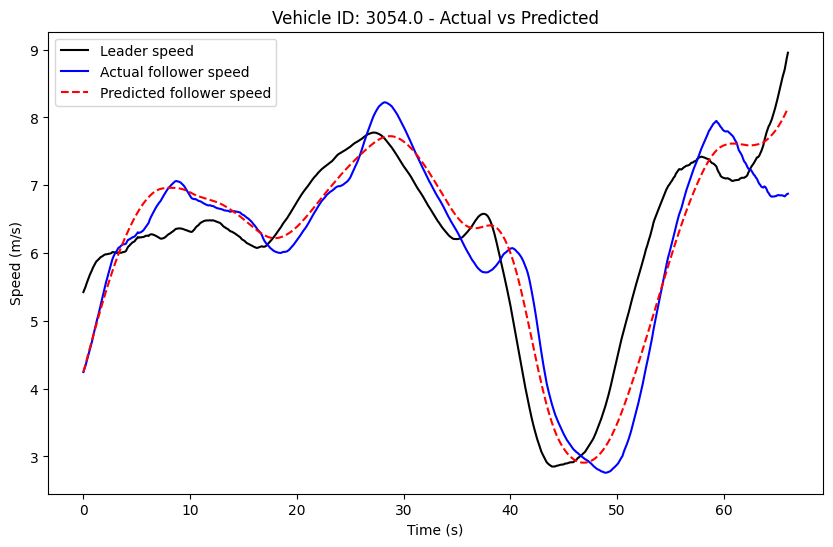

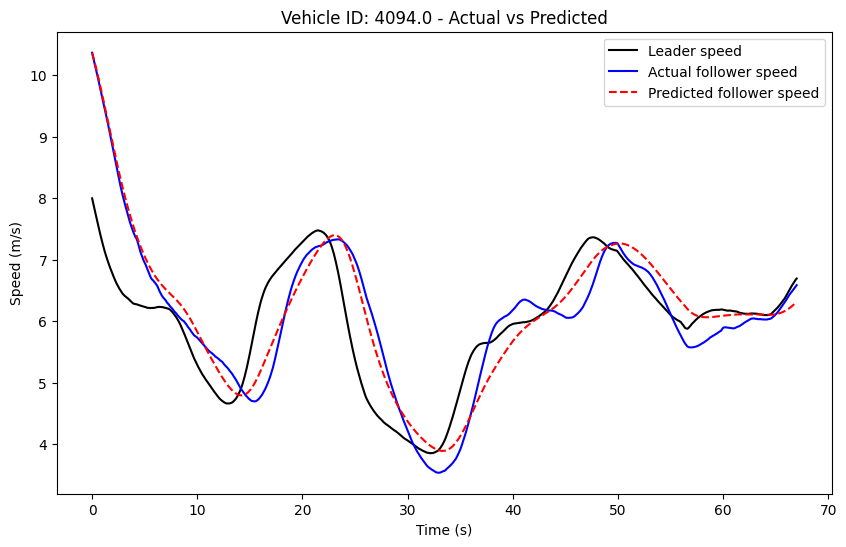

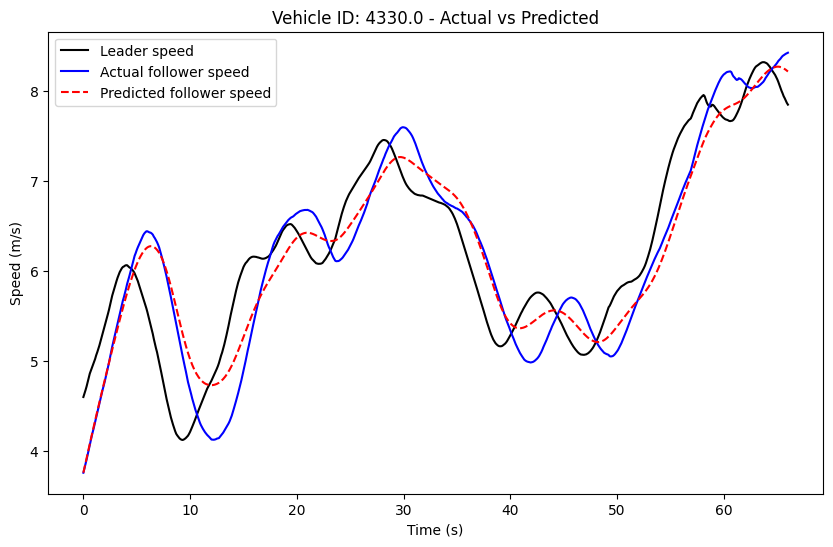

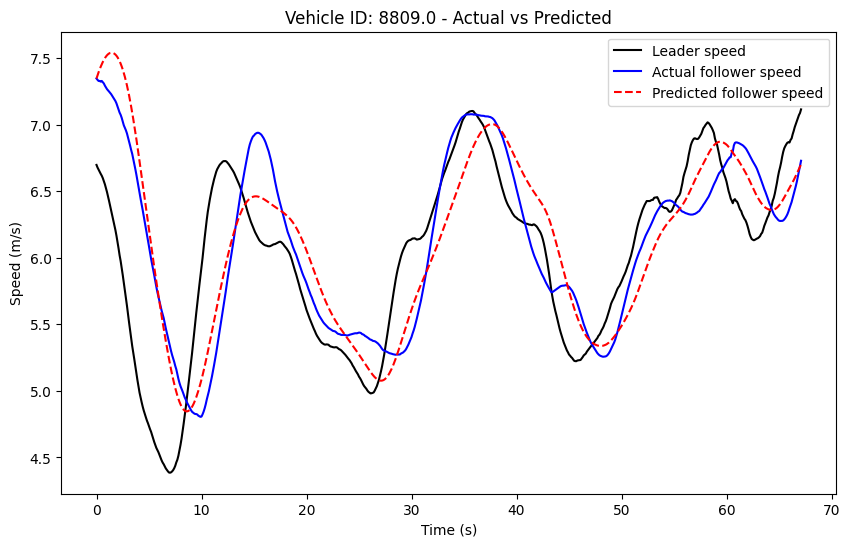

Mean validation MSE: 0.14406827751425622


In [6]:
import matplotlib.pyplot as plt

vali_index = []
time_step = 0.1

grouped = test_data.groupby('Vehicle_ID_f')

for vehicle_id, data in grouped:
    # Initial follower state
    v_f = data['v_f'].iloc[0]
    x_f = data['x_f'].iloc[0]
    a_f = data['a_f'].iloc[0]

    # Leader trajectories
    v_l = data['v_l'].values
    x_l = data['x_l'].values

    # Observed follower trajectories
    v_obs = data['v_f'].values
    x_obs = data['x_f'].values

    # Initialize simulated trajectories
    v_sim = [v_f]
    x_sim = [x_f]
    a_sim = [a_f]

    # Step through trajectory
    for i in range(1, len(data)):
        s = x_l[i] - x_sim[-1] - data['length_l'].iloc[i]
        delta_v = v_sim[-1] - v_l[i]

        acc = idm_model(s, v_sim[-1], delta_v, calibrated_params)

        new_v = v_sim[-1] + acc * time_step
        new_x = x_sim[-1] + new_v * time_step

        v_sim.append(new_v)
        x_sim.append(new_x)
        a_sim.append(acc)

    # Least Squares error (MSE on speed)
    error = np.mean((v_obs - np.array(v_sim))**2)
    vali_index.append(error)

    # Plot actual vs predicted speed
    t = np.arange(len(data)) * time_step
    plt.figure(figsize=(10, 6))
    plt.plot(t, v_l, label="Leader speed", color="black", linestyle='-')
    plt.plot(t, v_obs, label="Actual follower speed", color="blue", linestyle='-')
    plt.plot(t, v_sim, label="Predicted follower speed", color="red", linestyle='--')
    plt.title(f"Vehicle ID: {vehicle_id} - Actual vs Predicted")
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (m/s)")
    plt.legend()
    plt.show()

vali_index = np.array(vali_index)
print("Mean validation MSE:", np.mean(vali_index))


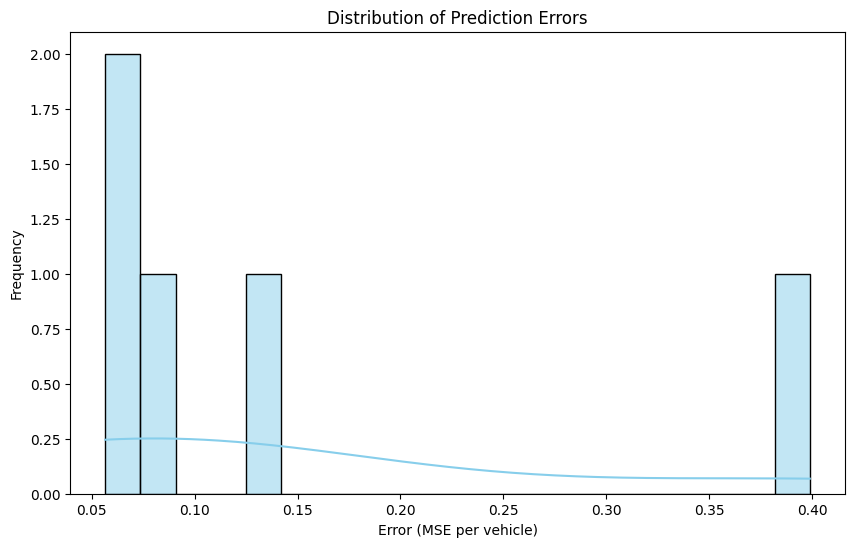

Shapiro-Wilk test statistic: 0.7062012826243301
p-value: 0.011106748850581034
Errors deviate significantly from normal distribution (reject H0).


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 4. Histogram representing the distribution of the prediction error
plt.figure(figsize=(10,6))
sns.histplot(vali_index, bins=20, kde=True, color="skyblue")
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (MSE per vehicle)")
plt.ylabel("Frequency")
plt.show()

# Verify if it belongs to a specific distribution
# Example: Shapiro-Wilk test for normality
stat, p_value = stats.shapiro(vali_index)
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p_value)

if p_value > 0.05:
    print("Errors look consistent with a normal distribution (fail to reject H0).")
else:
    print("Errors deviate significantly from normal distribution (reject H0).")

# It would be great if your report includes:
1. Which GoF is better in IDM model calibration?
2. Which MoP is better in IDM model calibration?
3. Which optimization algorithm is better in IDM model calibration?
4. How to validate the calibrated IDM model?
5. What is prediction error distribution of the estimated model?
6. Plot: Predicted Trajectory vs. True Trajectory, Predicted Speed vs. True Speed.